In [1]:
!pip install yfinance

  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached multitasking-0.0.12.tar.gz (19 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached peewee-3.18.2.tar.gz (949 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl.metadata (13 kB)
  Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
Using cached yfinance-0.2

In [2]:
! pip install pandas numpy tensorflow scikit-learn matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [3]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [4]:

class YahooFeed:
    def __init__(self, symbol=" EURUSD=X"):
        self.symbol = symbol
        # from min to max
        self.periods = ["1d", "5d", "1mo", "3mo", "6mo", "1y", "2y"]
        self.intervals = ["1m", "2m", "5m", "15m", "30m", "60m", "90m",
                          "1d", "5d", "1wk", "1mo", "3mo"]

        # find valid comibination
        self.period, self.interval = self._find_valid_combination()

    def _find_valid_combination(self):
        """اولین ترکیب معتبر period و interval را پیدا می‌کند"""
        for it in self.intervals:      # first interval (from min to max)
            for p in self.periods:     # next period
                try:
                    print(f"Trying period={p}, interval={it} ...")
                    df = yf.download(tickers=self.symbol, period=p, interval=it, progress=False)
                    if not df.empty:
                        print(f"✅ Found valid: period={p}, interval={it}")
                        return p, it
                except Exception:
                    continue
        raise ValueError(f"No valid period/interval found for {self.symbol}")

    def fetch_candles(self, count=1500):
        """دانلود دیتا با ترکیب معتبر پیدا شده"""
        df = yf.download(tickers=self.symbol, period=self.period, interval=self.interval, progress=False)
        df = df[['Open','High','Low','Close','Volume']].reset_index()
        df.rename(columns={'Open':'open','High':'high','Low':'low',
                           'Close':'close','Volume':'volume',
                           'Date':'datetime'}, inplace=True)
        return df.tail(count)

In [5]:

# ----------------------------
# Zone Detection
# ----------------------------
@dataclass
class Zone:
    type: str
    low: float
    high: float

def detect_zones(df, distance=0.0005):
    zones = []
    if len(df) < 3:
        return zones
    lows = df['low'].values
    highs = df['high'].values

    demand_condition = (lows[1:-1] < lows[:-2]) & (lows[1:-1] < lows[2:])
    supply_condition = (highs[1:-1] > highs[:-2]) & (highs[1:-1] > highs[2:])

    demand_indices = np.where(demand_condition)[0] + 1
    supply_indices = np.where(supply_condition)[0] + 1

    for i in demand_indices:
        low = float(lows[i])
        high = low + distance
        zones.append(Zone("demand", low, high))

    for i in supply_indices:
        high = float(highs[i])
        low = high - distance
        zones.append(Zone("supply", low, high))

    return zones


In [6]:
# ----------------------------
# Signal Engine
# ----------------------------
@dataclass
class Signal:
    time: pd.Timestamp
    kind: str
    entry: float
    sl: float
    tp: float
    remark: str = ""

class SignalEngine:
    def generate(self, df, zones, predicted_close):
        signals = []
        if df.empty:
            return signals

        last_close = float(df['close'].iloc[-1])
        last_time = df['Datetime'].iloc[-1]  # using real datetime column

        for z in zones:
            low = float(z.low)
            high = float(z.high)
            if z.type == "demand" and last_close <= high:
                signals.append(Signal(
                    time=last_time,
                    kind="buy",
                    entry=last_close,
                    sl=last_close-0.001,
                    tp=last_close+0.002,
                    remark=f"Zone + AI Pred:{predicted_close:.5f}"
                ))
            elif z.type == "supply" and last_close >= low:
                signals.append(Signal(
                    time=last_time,
                    kind="sell",
                    entry=last_close,
                    sl=last_close+0.001,
                    tp=last_close-0.002,
                    remark=f"Zone + AI Pred:{predicted_close:.5f}"
                ))

        # سیگنال AI
        if predicted_close > last_close:
            signals.append(Signal(
                time=last_time,
                kind="buy",
                entry=last_close,
                sl=last_close-0.001,
                tp=last_close+0.002,
                remark="AI bullish"
            ))
        elif predicted_close < last_close:
            signals.append(Signal(
                time=last_time,
                kind="sell",
                entry=last_close,
                sl=last_close+0.001,
                tp=last_close-0.002,
                remark="AI bearish"
            ))

        return signals

In [7]:

# ----------------------------
#  fetching data and  Feature Engineering
# ----------------------------

feed = YahooFeed("EURUSD=X")
df = feed.fetch_candles()
print(df.head())

if df.empty:
    raise ValueError("Failed to fetch data. Check symbol, period, and interval.")

df['body'] = df['close'] - df['open']
df['upper_wick'] = df['high'] - np.maximum(df['close'], df['open'])
df['lower_wick'] = np.minimum(df['close'], df['open']) - df['low']

features = ['open','high','low','close','volume','body','upper_wick','lower_wick']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


Trying period=1d, interval=1m ...


C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\1684682647.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=self.symbol, period=p, interval=it, progress=False)


✅ Found valid: period=1d, interval=1m


C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\1684682647.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=self.symbol, period=self.period, interval=self.interval, progress=False)


Price                   Datetime      open      high       low     close  \
Ticker                            EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X   
0      2025-10-21 23:00:00+00:00  1.160362  1.160362  1.160362  1.160362   
1      2025-10-21 23:01:00+00:00  1.160362  1.160362  1.160362  1.160362   
2      2025-10-21 23:02:00+00:00  1.160362  1.160362  1.160362  1.160362   
3      2025-10-21 23:03:00+00:00  1.160362  1.160362  1.160362  1.160362   
4      2025-10-21 23:04:00+00:00  1.160362  1.160362  1.160362  1.160362   

Price    volume  
Ticker EURUSD=X  
0             0  
1             0  
2             0  
3             0  
4             0  


In [8]:
df.head()

Price                   Datetime      open      high       low     close  \
Ticker                            EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X   
0      2025-10-21 23:00:00+00:00  0.514181  0.514181  0.514181  0.514181   
1      2025-10-21 23:01:00+00:00  0.514181  0.514181  0.514181  0.514181   
2      2025-10-21 23:02:00+00:00  0.514181  0.514181  0.514181  0.514181   
3      2025-10-21 23:03:00+00:00  0.514181  0.514181  0.514181  0.514181   
4      2025-10-21 23:04:00+00:00  0.514181  0.514181  0.514181  0.514181   

Price    volume body upper_wick lower_wick  
Ticker EURUSD=X                             
0           0.0  0.0        0.0        0.0  
1           0.0  0.0        0.0        0.0  
2           0.0  0.0        0.0        0.0  
3           0.0  0.0        0.0        0.0  
4           0.0  0.0        0.0        0.0

In [9]:

# ----------------------------
# Detecting Zones
# ----------------------------
zones = detect_zones(df)

# Print first 5 zones
for z in zones[:5]:
    print(f"{z.type} zone | low: {z.low:.5f}, high: {z.high:.5f}")


demand zone | low: 0.51418, high: 0.51468
demand zone | low: 0.54450, high: 0.54500
demand zone | low: 0.60514, high: 0.60564
demand zone | low: 0.60514, high: 0.60564
demand zone | low: 0.63546, high: 0.63596


C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\2483903953.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  low = float(lows[i])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\2483903953.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  high = float(highs[i])


In [10]:

# ----------------------------
# Preparing Data for LSTM
# ----------------------------
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(df)):
    X.append(df[features].iloc[i-sequence_length:i].values)
    y.append(df['close'].iloc[i])
X = np.array(X)
y = np.array(y)


In [11]:
# Splitting into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [12]:
# Defining the model
model = Sequential([
    LSTM(256, input_shape=(sequence_length, len(features)), return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(64, return_sequences=False),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # predicting next candle price
])

# compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# ----------------------------
# Callbacks
# ----------------------------

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint("best_lstm_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
]

# ----------------------------
# Training the model
# ----------------------------
history = model.fit(
    X, y,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=callbacks
)

c:\Users\Pouya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2127 - mae: 0.3595
Epoch 1: val_loss improved from None to 0.04774, saving model to best_lstm_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.1171 - mae: 0.2617 - val_loss: 0.0477 - val_mae: 0.2131 - learning_rate: 0.0010
Epoch 2/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0401 - mae: 0.1593
Epoch 2: val_loss improved from 0.04774 to 0.01094, saving model to best_lstm_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0399 - mae: 0.1572 - val_loss: 0.0109 - val_mae: 0.0931 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0308 - mae: 0.1355
Epoch 3: val_loss improved from 0.01094 to 0.00399, saving model to best_lstm_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0298 - mae: 0.1332 - val_loss: 0.0040 - val_mae: 0.0560 - learning_rate: 0.0010
Epoch 4/50
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0272 - mae: 0.1285
Epoch 4: val_loss improved from 0.00399 to 0.00331, saving model to best_lstm_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0247 - mae: 0.1243 - val_loss: 0.0033 - val_mae: 0.0510 - learning_rate: 0.0010
Epoch 5/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0248 - mae: 0.1232
Epoch 5: val_loss did not improve from 0.00331
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0230 - mae: 0.1182 - val_loss: 0.0047 - val_mae: 0.0525 - learning_rate: 0.0010
Epoch 6/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0187 - mae: 0.1047
Epoch 6: val_loss improved from 0.00331 to 0.00321, saving model to best_lstm_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0192 - mae: 0.1067 - val_loss: 0.0032 - val_mae: 0.0502 - learning_rate: 0.0010
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0176 - mae: 0.1042
Epoch 7: val_loss did not improve from 0.00321
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0187 - mae: 0.1073 - val_loss: 0.0035 - val_mae: 0.0522 - learning_rate: 0.0010
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0173 - mae: 0.1014
Epoch 8: val_loss did not improve from 0.00321
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0157 - mae: 0.0975 - val_loss: 0.0105 - val_mae: 0.0923 - learning_rate: 0.0010
Epoch 9/50
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0181 - mae: 0.1033
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_loss did not improve from 0.00321
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0162 - mae: 0.0978 - val_loss: 0.0106 - val_mae: 0.0928 - learning_rate: 0.0010
Epoch 10/50
32/34 ━━━━

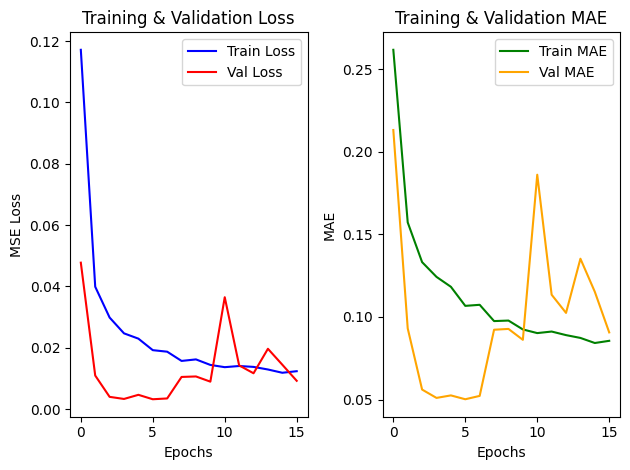

In [13]:

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()

# MAE
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
if 'val_mae' in history.history:
    plt.plot(history.history['val_mae'], label='Val MAE', color='orange')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training & Validation MAE")
plt.legend()

plt.tight_layout()
plt.show()

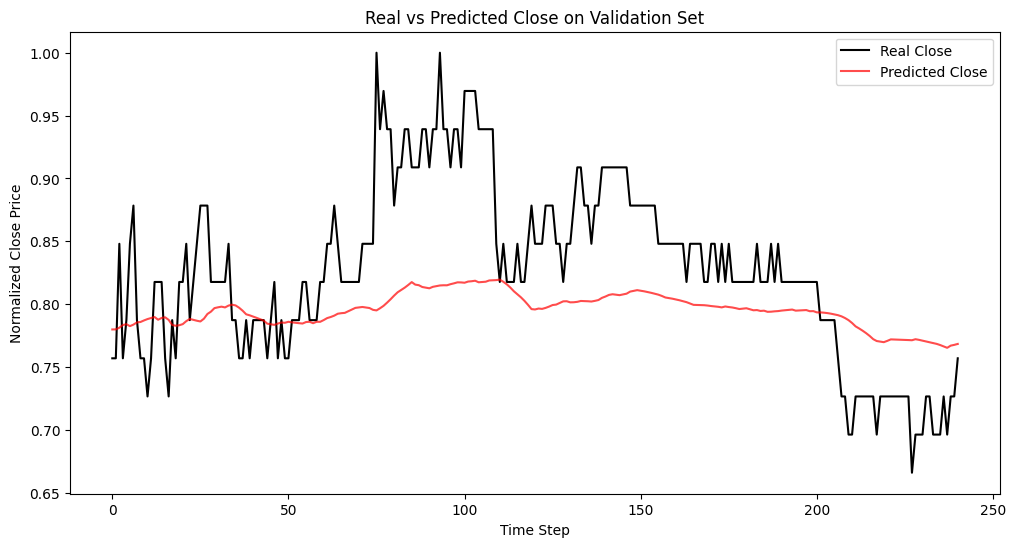

In [14]:
# predicting on validation set
y_val_pred = model.predict(X_val, verbose=0).flatten()

# Visualizing the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(len(y_val)), y_val, label='Real Close', color='black')
plt.plot(range(len(y_val_pred)), y_val_pred, label='Predicted Close', color='red', alpha=0.7)
plt.title("Real vs Predicted Close on Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.show()


In [15]:
# ----------------------------
# Signal Generation
# ----------------------------
engine = SignalEngine()
history_signals = []

for i in range(sequence_length, len(df)):
    seq = df[features].iloc[i-sequence_length:i].values.reshape(1, sequence_length, len(features))
    predicted_close = float(model.predict(seq, verbose=0)[0][0])

    current_df = df.iloc[:i+1].copy()
    current_df.reset_index(drop=True, inplace=True)

    current_zones = detect_zones(current_df)
    signals = engine.generate(current_df, current_zones, predicted_close)

    for s in signals[:5]:
        history_signals.append(s)
        # print(f"[SIGNAL] {s.time} | {s.kind.upper()} | entry={s.entry:.5f} | SL={s.sl:.5f} | TP={s.tp:.5f} | {s.remark}")

C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\2680011337.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close = float(df['close'].iloc[-1])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\2680011337.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close = float(df['close'].iloc[-1])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\2483903953.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  high = float(highs[i])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\2680011337.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Us

In [16]:
def export_signals(signals, filename="signals_history.csv"):
    # Convert signals to DataFrame
    data = []
    for s in signals:
        data.append({
            "time": s.time,
            "type": s.kind,
            "entry": s.entry,
            "sl": s.sl,
            "tp": s.tp,
            "remark": s.remark
        })

    df_signals = pd.DataFrame(data)

    # Save to CSV
    df_signals.to_csv(filename, index=False, encoding="utf-8-sig")
    print(f"✅ Signals exported to {filename}")

    return df_signals


In [17]:
signals_df = export_signals(history_signals, "signals_history.csv")

✅ Signals exported to signals_history.csv


In [18]:
signals_df.head()

time  type     entry        sl        tp  \
0 2025-10-21 23:10:00+00:00   buy  0.514181  0.513181  0.516181   
1 2025-10-21 23:11:00+00:00   buy  0.544501  0.543501  0.546501   
2 2025-10-21 23:12:00+00:00   buy  0.514181  0.513181  0.516181   
3 2025-10-21 23:13:00+00:00  sell  0.544501  0.545501  0.542501   
4 2025-10-21 23:13:00+00:00   buy  0.544501  0.543501  0.546501   

                   remark  
0              AI bullish  
1              AI bullish  
2              AI bullish  
3  Zone + AI Pred:0.72522  
4              AI bullish

In [19]:
print("Sample signals times:", [s.time for s in history_signals[:5]])
print("DataFrame Datetime head:", df['Datetime'].head())

Sample signals times: [Timestamp('2025-10-21 23:10:00+0000', tz='UTC'), Timestamp('2025-10-21 23:11:00+0000', tz='UTC'), Timestamp('2025-10-21 23:12:00+0000', tz='UTC'), Timestamp('2025-10-21 23:13:00+0000', tz='UTC'), Timestamp('2025-10-21 23:13:00+0000', tz='UTC')]
DataFrame Datetime head: 0   2025-10-21 23:00:00+00:00
1   2025-10-21 23:01:00+00:00
2   2025-10-21 23:02:00+00:00
3   2025-10-21 23:03:00+00:00
4   2025-10-21 23:04:00+00:00
Name: Datetime, dtype: datetime64[ns, UTC]


In [20]:
def backtest_signals(df, signals, look_ahead=20):
    """
    Backtest signals by comparing future candles.
    - df: DataFrame containing Datetime and OHLC columns
    - signals: List of Signal
    - look_ahead: Number of candles to check after the signal
    """
    # Ensure Datetime column is present
    if "Datetime" not in df.columns:
        if "Date" in df.columns:
            df = df.rename(columns={"Date": "Datetime"})
        else:
            df = df.reset_index().rename(columns={df.columns[0]: "Datetime"})

    # UTC-naive col datetime
    df['Datetime'] = pd.to_datetime(df['Datetime']).dt.tz_localize(None)

    results = []

    for s in signals:
        # Signal time
        sig_time = pd.to_datetime(s.time).tz_localize(None) if isinstance(s.time, pd.Timestamp) else pd.to_datetime(s.time)

        # Find signal index
        idx_list = df.index[df['Datetime'] == sig_time].tolist()
        if not idx_list:
            continue
        idx = idx_list[0]

        # Future data
        future = df.iloc[idx:idx+look_ahead]

        outcome = "Open"
        exit_price = s.entry

        for _, row in future.iterrows():
            high = float(row['high'])
            low = float(row['low'])

            if s.kind == "buy":
                if low <= s.sl:
                    outcome = "Loss"
                    exit_price = s.sl
                    break
                elif high >= s.tp:
                    outcome = "Win"
                    exit_price = s.tp
                    break
            elif s.kind == "sell":
                if high >= s.sl:
                    outcome = "Loss"
                    exit_price = s.sl
                    break
                elif low <= s.tp:
                    outcome = "Win"
                    exit_price = s.tp
                    break

        results.append({
            "Datetime": sig_time,
            "kind": s.kind,
            "entry": s.entry,
            "sl": s.sl,
            "tp": s.tp,
            "exit": exit_price,
            "outcome": outcome,
            "remark": s.remark
        })

    df_results = pd.DataFrame(results)

    # Calculate Win Rate
    if not df_results.empty:
        win_rate = (df_results['outcome'] == "Win").mean() * 100
        print(f"Total signals: {len(df_results)}, Win Rate: {win_rate:.2f}%")
    else:
        print("No backtest results generated. Check signals or DataFrame alignment.")

    return df_results


In [21]:
results_df = backtest_signals(df, history_signals)
results_df.head()


C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\708897075.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  high = float(row['high'])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\708897075.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  low = float(row['low'])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\708897075.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  high = float(row['high'])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\708897075.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  low = float(row['low'])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\7088970

Total signals: 5848, Win Rate: 50.67%


C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\708897075.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  high = float(row['high'])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\708897075.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  low = float(row['low'])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\708897075.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  high = float(row['high'])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\708897075.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  low = float(row['low'])
C:\Users\Pouya\AppData\Local\Temp\ipykernel_4712\7088970

Datetime  kind     entry        sl        tp      exit outcome  \
0 2025-10-21 23:10:00   buy  0.514181  0.513181  0.516181  0.516181     Win   
1 2025-10-21 23:11:00   buy  0.544501  0.543501  0.546501  0.543501    Loss   
2 2025-10-21 23:12:00   buy  0.514181  0.513181  0.516181  0.516181     Win   
3 2025-10-21 23:13:00  sell  0.544501  0.545501  0.542501  0.542501     Win   
4 2025-10-21 23:13:00   buy  0.544501  0.543501  0.546501  0.543501    Loss   

                   remark  
0              AI bullish  
1              AI bullish  
2              AI bullish  
3  Zone + AI Pred:0.72522  
4              AI bullish

In [22]:
# Save backtest results to CSV
results_df.to_csv("backtest_results.csv", index=False, encoding="utf-8-sig")

print("✅ Backtest results saved to backtest_results.csv")

✅ Backtest results saved to backtest_results.csv


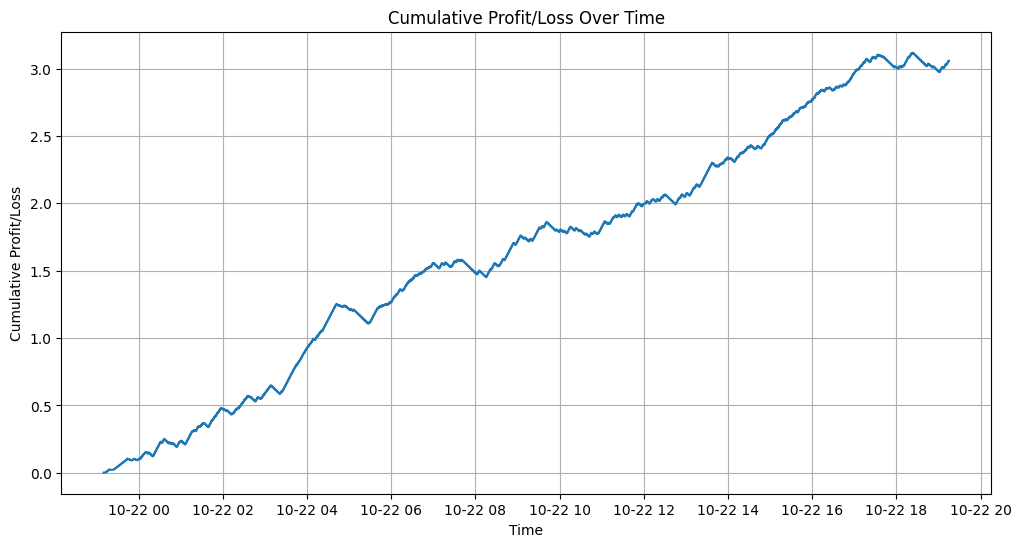

In [23]:
# Calculate profit/loss for each trade
def calculate_trade_profit_loss(row):
    if row['outcome'] == 'Win':
        # Assuming TP is higher than entry for buy, and lower for sell
        return abs(row['exit'] - row['entry'])
    elif row['outcome'] == 'Loss':
        # Assuming SL is lower than entry for buy, and higher for sell
        return -abs(row['exit'] - row['entry'])
    else:
        return 0

results_df['profit_loss'] = results_df.apply(calculate_trade_profit_loss, axis=1)

# Calculate cumulative profit/loss
results_df['cumulative_profit_loss'] = results_df['profit_loss'].cumsum()

# Plot cumulative profit/loss
plt.figure(figsize=(12, 6))
plt.plot(results_df['Datetime'], results_df['cumulative_profit_loss'])
plt.title('Cumulative Profit/Loss Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit/Loss')
plt.grid(True)
plt.show()

In [24]:
# Calculate additional performance metrics

# Ensure 'profit_loss' column exists
if 'profit_loss' not in results_df.columns:
     def calculate_trade_profit_loss(row):
        if row['outcome'] == 'Win':
            return abs(row['exit'] - row['entry'])
        elif row['outcome'] == 'Loss':
            return -abs(row['exit'] - row['entry'])
        else:
            return 0
     results_df['profit_loss'] = results_df.apply(calculate_trade_profit_loss, axis=1)

# Ensure 'cumulative_profit_loss' column exists
if 'cumulative_profit_loss' not in results_df.columns:
    results_df['cumulative_profit_loss'] = results_df['profit_loss'].cumsum()

# Calculate Daily Returns (assuming each row is a "trade" or point in time)
# For simplicity, let's assume each row represents a period where the profit/loss occurred
# Calculate returns (profit/loss per trade)
returns = results_df['profit_loss']

# Sharpe Ratio (annualized)
if len(returns) > 1 and returns.std() != 0:
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.4f}")
else:
    print("Sharpe Ratio cannot be calculated (not enough data).")

# Equity curve
initial_capital = 1.0
equity_curve = initial_capital + results_df['cumulative_profit_loss']

# Maximum Drawdown
peak = equity_curve.expanding(min_periods=1).max()
drawdown = (equity_curve - peak) / peak
maximum_drawdown = drawdown.min()
print(f"Maximum Drawdown: {maximum_drawdown:.4f}")

# Calmar Ratio
total_return = equity_curve.iloc[-1] / equity_curve.iloc[0] - 1
if abs(maximum_drawdown) > 1e-8:
    calmar_ratio = total_return / abs(maximum_drawdown)
    print(f"Calmar Ratio: {calmar_ratio:.4f}")
else:
    print("Calmar Ratio undefined (drawdown is zero).")


Sharpe Ratio (Annualized): 5.5413
Maximum Drawdown: -0.0644
Calmar Ratio: 47.3681
